# PDEs

In [1]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

## Elliptic (Poisson)

$\frac{d^2 y}{dx^2}=12x^2$ for $x=[0,1]$ with $y(0)=0$ and $y(1)=0$.
The exact solution $y(x)=x^4-4$.

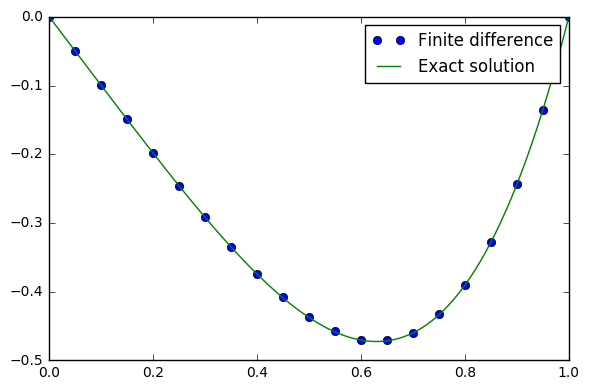

In [30]:
M = 20
h = 1./M

x = np.linspace(0, 1, M+1).T

b = np.zeros(M+1) 
b[1:M] = 12*(h*x[1:M])**2

main_diag = -2*np.ones(M+1)
off_diag  = 1*np.ones(M+1)

diagonals = [main_diag, off_diag, off_diag]
A = sparse.diags(diagonals, [0,-1,1], shape=(M+1,M+1)).toarray()

A[0, 0] = 1
A[0, 1] = 0
A[M, M] = 1
A[M, M-1] = 0

#print(A)

y = np.linalg.solve(A,b)

xf = np.linspace(0,1,100)
yexact = xf**4 - xf

plt.plot(x, y, 'o')
plt.plot(xf, yexact)
plt.legend(['Finite difference', 'Exact solution'])
plt.tight_layout()
plt.show()

## 2D

$-\nabla^2 u = 20\cos (30\pi x)\sin(2\pi y)$

$R=\{(x,y) | 0<x< 1, 0<y<1 \}$ with 


$u(0,y)=y^2, \quad u(x,0)= x^3, \quad  u(x, 1)= 1, \quad u(1, y)=1$

In [90]:
def generate_lhs_matrix(M, hx, hy): 
    alpha = hx**2/hy**2

    main_diag = 2 * (1 + alpha) * np.ones(M - 2)
    off_diag  = -1 * np.ones(M - 2)
    
    a = len(main_diag)

    diagonals = [main_diag, off_diag, off_diag]
    B  = sparse.diags(diagonals, [0, -1, 1], shape=(a, a)).toarray()
    #print(B)
    
    e1 = sparse.eye(M-2).toarray() 
    #Repeat and fill up with zeros
    A1 = sparse.kron(e1,B).toarray()
    #print(A1)
    
    C = sparse.diags([-1*np.ones(M+1)], [0], shape=(a,a)).toarray()
    e2 = sparse.diags([1*np.ones(M),1*np.ones(M)], [-1,1], shape=(a,a)).toarray()    
    A2 = sparse.kron(e2,C).toarray()

    return A1+A2

In [109]:
def bc_dirichlet(X, Y, M):
    lBC = Y[:,0]**2
    leftBC = lBC[1:M-1]
    
    rBC = np.ones(M)
    rightBC = rBC[1:M-1]
    
    tBC = X[0,:]**3
    topBC = tBC[1:M-1]
    
    bBC = np.ones(M)
    bottomBC = bBC[1:M-1]
    
    g1 = np.zeros((M-2)**2)
    
    for i in range(M-2):
        g1[(M-2)*i]       = topBC[i] 
        g1[(M-2)*(i+1)-1] = bottomBC[i]
    
    k1 = np.zeros(len(leftBC))
    k1[0] = 1.0
    leftBCk = sparse.kron(k1, leftBC).toarray().flatten()
    
    k2 = np.zeros(len(rightBC))
    k2[-1] = 1.0
    rightBCk = sparse.kron(k2,rightBC).toarray().flatten()
    
    g = g1 + leftBCk + rightBCk
    
    return [g, lBC, tBC, rBC, bBC]

In [118]:
def rhs_func(x, y, M):
    g = (20 * np.multiply(np.cos(3*np.pi*X[1:-1, 1:-1]), np.sin(2*np.pi*Y[1:-1, 1:-1]))).flatten()
    f = [g[i::M-2] for i in range(M-2)] 
    f = np.asarray(f).flatten() 
    return f

In [143]:
M = 100
(x0, xf) = (0.0, 1.0)
(y0, yf) = (0.0, 1.0)

hx = (xf - x0)/(M-1)
hy = (yf - y0)/(M-1)

x1 = np.linspace(x0, xf, M)
y1 = np.linspace(y0, yf, M)

X, Y = np.meshgrid(x1, y1)


#---
A = generate_lhs_matrix(M, hx, hy)

fbc = bc_dirichlet(X, Y, M)

frhs = rhs_func(X, Y, M)

rhs = frhs*(hx**2) + fbc[0]

V = np.linalg.solve(A,rhs)

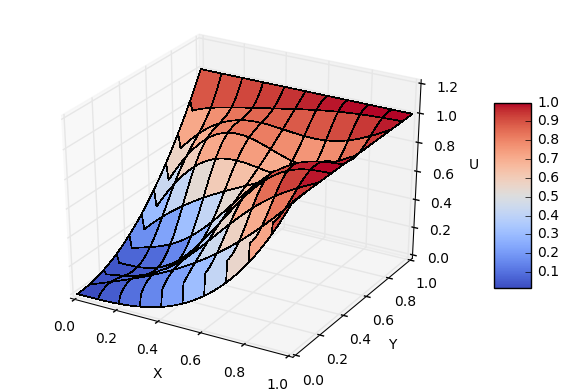

In [144]:
V = V.reshape((M-2, M-2))

U = np.zeros((M,M))

U[1:M-1, 1:M-1] = V
U[:,0]   = fbc[1]
U[0,:]   = fbc[2]
U[:,M-1] = fbc[3]
U[M-1,:] = fbc[4]

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, U, cmap=cm.coolwarm,
                       linewidth=0.5, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('U')
plt.tight_layout()
#ax.view_init(20, -106)
plt.show()

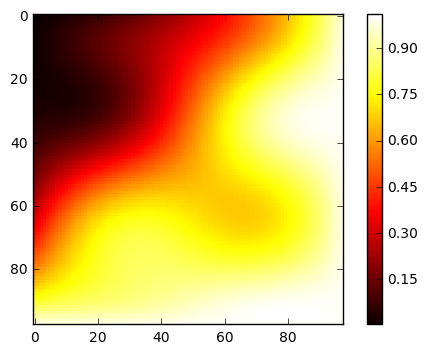

In [147]:
plt.imshow(V, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

Iteration finished


/usr/local/lib/python3.5/site-packages/numpy/ma/core.py:6554: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/site-packages/numpy/ma/core.py:6554: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


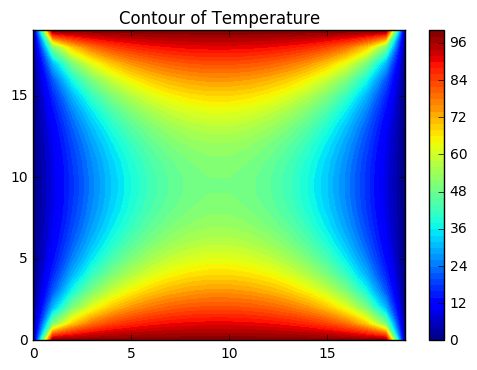

In [3]:
# Simple Numerical Laplace Equation Solution using Finite Difference Method
import numpy as np
import matplotlib.pyplot as plt

# Set maximum iteration
maxIter = 500

# Set Dimension and delta
lenX = lenY = 20 #we set it rectangular
delta = 1

# Boundary condition
Ttop = 100
Tbottom = 100
Tleft = 0
Tright = 0

# Initial guess of interior grid
Tguess = 30

# Set meshgrid
X, Y = np.meshgrid(np.arange(0, lenX), np.arange(0, lenY))

# Set array size and set the interior value with Tguess
T = np.empty((lenX, lenY))
T.fill(Tguess)

# Set Boundary condition
T[(lenY-1):, :] = Ttop
T[:1, :] = Tbottom
T[:, (lenX-1):] = Tright
T[:, :1] = Tleft

# Iteration (We assume that the iteration is convergence in maxIter = 500)
#print("Please wait for a moment")
for iteration in range(0, maxIter):
    for i in range(1, lenX-1, delta):
        for j in range(1, lenY-1, delta):
            T[i, j] = 0.25 * (T[i+1][j] + T[i-1][j] + T[i][j+1] + T[i][j-1])

print("Iteration finished")

# Set colour interpolation and colour map
colorinterpolation = 50
colourMap = plt.cm.jet #you can try: colourMap = plt.cm.coolwarm

# Configure the contour
plt.title("Contour of Temperature")
plt.contourf(X, Y, T, colorinterpolation, cmap=colourMap)

# Set Colorbar
plt.colorbar()

# Show the result in the plot window
plt.show()

print("")

https://levelup.gitconnected.com/solving-2d-heat-equation-numerically-using-python-3334004aa01a

https://fenicsproject.org/pub/tutorial/sphinx1/._ftut1004.html

https://www.duo.uio.no/handle/10852/9697

https://hplgit.github.io/fdm-book/doc/pub/book/sphinx/genindex.html

# Parabolic PDE


$\frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial x^2}   + \alpha  u$
    
boundary conditions $u(x_0,t) = 0, u(x_L,t) = 0$
initial condition $u(x,0) = 4x - 4x^2$


In [9]:
M = 70 
N = 40 

x0, xL = 0, 1
t0, tF = 0, 0.2

dx = (xL - x0)/(M - 1)
dt = (tF - t0)/(N - 1)

D = 0.1  
alpha = -3 

r = D*(dt/dx**2)
s = dt*alpha

xspan = np.linspace(x0, xL, M)
tspan = np.linspace(t0, tF, N)

U = np.zeros((M, N))

U[:,0] = 4*xspan - 4*xspan**2

U[0,:] = 0.0
U[-1,:] = 0.0

In [12]:
#Forward time central space
for k in range(0, N-1):
    for i in range(1, M-1):
        U[i, k+1] =  (1-2*r+s)*U[i,k] + r*(U[i+1,k] + U[i-1, k])
        
#Backward method 
#main_diag = (1 + 2*r - s) #*np.ones(M-2)
#off_diag  = -r #*np.ones(M-3)

#diagonals = [main_diag, off_diag, off_diag]

#A = sparse.diags(diagonals, [0,-1,1], shape=(M-2,M-2)).toarray()

#for k in range(1, N):
#    b1 = np.asarray([r*U[0,k], r*U[-1,k]])
#    c  = np.zeros(M-4)
#    b1 = np.insert(b1, 1, c)
#    b2 = np.array(U[1:M-1, k-1])
#    b = b1 + b2  
#    U[1:M-1, k] = np.linalg.solve(A,b)

#CN method
#a0 = 1 + 2*r - s
#c0 = 1 - 2*r + s

#main_diag_a0 = a0*np.ones(M)
#off_diag_a0 = -r*np.ones(M-1)

#main_diag_c0 = c0*np.ones(M)
#off_diag_c0 = r*np.ones(M-1)

#diagonalsA = [main_diag_a0, off_diag_a0, off_diag_a0]
#A = sparse.diags(diagonalsA, [0,-1,1], shape=(M,M)).toarray()
#A[0,1] = -2*r
#A[M-1,M-2] = -2*r

#diagonalsC = [main_diag_c0, off_diag_c0, off_diag_c0]
#A_rhs = sparse.diags(diagonalsC, [0,-1,1], shape=(M,M)).toarray()
#A_rhs[0,1] = 2*r
#A_rhs[M-1,M-2] = 2*r

#leftBC = np.arange(1, N+1)
#f = np.sin(leftBC*np.pi/2)

#rightBC = np.arange(1, N+1)
#g = np.sin(3*rightBC*np.pi/4)

#for k in range(1, N):
#    ins = np.zeros(M-2)
#    b1 = np.asarray([4*r*dx*f[k], 4*r*dx*g[k]])
#    b1 = np.insert(b1, 1, ins)
#    b2 = np.matmul(A_rhs, np.array(U[0:M, k-1]))
#    b = b1 + b2  
#    U[0:M, k] = np.linalg.solve(A,b)  
    

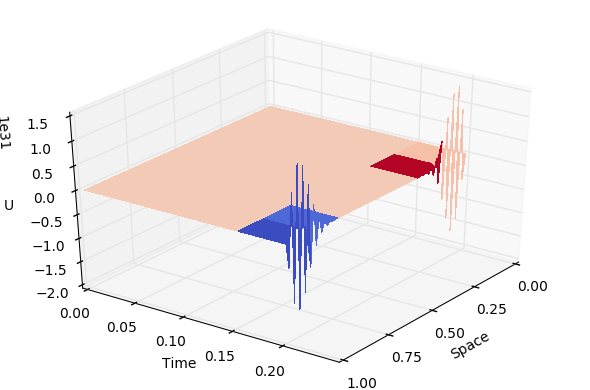

In [13]:
T, X = np.meshgrid(tspan, xspan)

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, T, U, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2])

ax.set_xlabel('Space')
ax.set_ylabel('Time')
ax.set_zlabel('U')
ax.view_init(elev=33, azim=36)
plt.tight_layout()
plt.show()

### In gral with libraries 
https://py-pde.readthedocs.io/en/latest/examples_gallery/index.html
    

In [175]:
import numpy as np
import matplotlib.pyplot as plt

dx=0.1 #space increment
dt=0.05 #time increment
tmin=0.0 #initial time
tmax=2.0 #simulate until
xmin=-5.0 #left bound
xmax=5.0 #right bound...assume packet never reaches boundary
c=1.0 #speed of sound
rsq=(c*dt/dx)**2 #appears in finite diff sol

nx = int((xmax-xmin)/dx) + 1 #number of points on x grid
nt = int((tmax-tmin)/dt) + 2 #number of points on t grid
u = np.zeros((nt,nx)) #solution to WE

#set initial pulse shape
def init_fn(x):
    val = np.exp(-(x**2)/0.25)
    if val<.001:
        return 0.0
    else:
        return val

for a in range(0,nx):
    u[0,a]=init_fn(xmin+a*dx)
    u[1,a]=u[0,a]

#simulate dynamics
for t in range(1,nt-1):
    for a in range(1,nx-1):
        u[t+1,a] = 2*(1-rsq)*u[t,a]-u[t-1,a]+rsq*(u[t,a-1]+u[t,a+1])


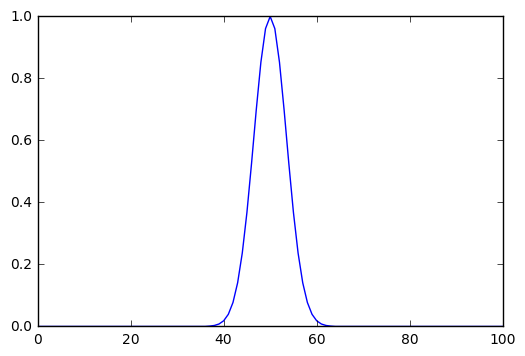

In [193]:
plt.plot(u[0,:])
plt.show()

In [195]:
# Given mesh points as arrays x and t (x[i], t[n])
dx = x[1] - x[0];  dt = t[1] - t[0]
C = c*dt/dx
N = len(t)-1
C2 = C**2                  # help variable in the scheme

# Set initial condition u(x,0) = I(x)
for i in range(0, Nx+1):
    u_1[i] = I(x[i])

# Apply special formula for first step, incorporating du/dt=0
for i in range(1, Nx):
    u[i] = u_1[i] - 0.5*C**2(u_1[i+1] - 2*u_1[i] + u_1[i-1])
u[0] = 0;  u[Nx] = 0

u_2[:], u_1[:] = u_1, u

for n in range(1, N):
    # Update all inner mesh points at time t[n+1]
    for i in range(1, Nx):
        u[i] = 2*u_1[i] - u_2[i] - \
               C**2(u_1[i+1] - 2*u_1[i] + u_1[i-1])

    # Insert boundary conditions
    u[0] = 0;  u[Nx] = 0

    # Switch variables before next step
    u_2[:], u_1[:] = u_1, u

TypeError: 'int' object is not subscriptable

In [ ]:
"""
This code solves the advection equation
    U_t + vU_x = 0

over the spatial domain of 0 <= x <= 1 that is discretized 
into 103 nodes, with dx=0.01, using the Lax-Friedrichs scheme 
in Eq. (18.17) for an initial profile of a Gaussian curve, 
defined by 
    U(x,t) = exp(-200*(x-xc-v*t).^2)

where xc=0.25 is the center of the curve at t=0.

The periodic boundary conditions are applied either end of the domain.
The velocity is v=1. The solution is iterated until t=1.5 seconds.
"""


import numpy as np
import matplotlib.pyplot as plt


class LaxFriedrichs:
    
    def __init__(self, N, tmax):
        self.N = N # number of nodes
        self.tmax = tmax
        self.xmin = 0
        self.xmax = 1
        self.dt = 0.009 # timestep
        self.v = 1 # velocity
        self.xc = 0.25
        self.initializeDomain()
        self.initializeU()
        self.initializeParams()
        
        
    def initializeDomain(self):
        self.dx = (self.xmax - self.xmin)/self.N
        self.x = np.arange(self.xmin-self.dx, self.xmax+(2*self.dx), self.dx)
        
        
    def initializeU(self):
        u0 = np.exp(-200*(self.x-self.xc)**2)
        self.u = u0.copy()
        self.unp1 = u0.copy()
        
        
    def initializeParams(self):
        self.nsteps = round(self.tmax/self.dt)
        self.alpha = self.v*self.dt/(2*self.dx)
        
        
    def solve_and_plot(self):
        tc = 0
        
        for i in range(self.nsteps):
            plt.clf()
            
            # The Lax-Friedrichs scheme, Eq. (18.17)
            for j in range(self.N+2):
                self.unp1[j] = self.u[j] - self.alpha*(self.u[j+1] - self.u[j-1]) + \
                (1/2)*(self.u[j+1] - 2*self.u[j] + self.u[j-1])
                
            self.u = self.unp1.copy()
            
            # Periodic boundary conditions
            self.u[0] = self.u[self.N+1]
            self.u[self.N+2] = self.u[1]
            
            uexact = np.exp(-200*(self.x-self.xc-self.v*tc)**2)
            
            plt.plot(self.x, uexact, 'r', label="Exact solution")
            plt.plot(self.x, self.u, 'bo-', label="Lax-Friedrichs")
            plt.axis((self.xmin-0.12, self.xmax+0.12, -0.2, 1.4))
            plt.grid(True)
            plt.xlabel("Distance (x)")
            plt.ylabel("u")
            plt.legend(loc=1, fontsize=12)
            plt.suptitle("Time = %1.3f" % (tc+self.dt))
            plt.pause(0.01)
            tc += self.dt


def main():
    sim = LaxFriedrichs(100, 1.5)
    sim.solve_and_plot()
    plt.show()
    
    
if __name__ == "__main__":
    main()

#N = 100  
#tmax = 2.5 # maximum value of t